<a href="https://colab.research.google.com/github/tanqing2001/datafile/blob/main/Final_Prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [8]:
#dateparse = lambda x: pd.datetime.strptime(x, '%d-%b-%y')
def dateparse(x):
    try:
        # Try parsing the date with the first format (before April 21, 2020)
        return pd.to_datetime(x, format='%d-%b-%y')
        #return pd.to_datetime(x, format='%m/%d/%Y')  ##GOLD
    except ValueError:
        # If the first format fails, try the second format (on or after April 22, 2020)
        return pd.to_datetime(x, format='%b %d, %Y')

#Read csv file
#url = "https://raw.githubusercontent.com/tanqing2001/datafile/main/BrentOilPrices.csv"
url = "https://raw.githubusercontent.com/tanqing2001/datafile/main/OilPrices.csv"
#url = "https://raw.githubusercontent.com/tanqing2001/datafile/main/GOLD.csv" #GOLD

df = pd.read_csv(url,parse_dates=['Date'], date_parser=dateparse)
#df = pd.read_csv(url)
df.head(5)

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [10]:
df.shape

(6069, 1)

In [9]:
#df.head(5)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(ascending=True, inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [ ]:
df.tail(5)

,Price
Date,
2023-11-17,77.53
2023-11-20,80.47
2023-11-21,82.13
2023-11-22,82.40
2023-11-23,81.63


In [ ]:
type(df)

pandas.core.frame.DataFrame

In [15]:
df.head()


,Price
Date,
2000-01-04,23.95
2000-01-05,23.72
2000-01-06,23.55
2000-01-07,23.35
2000-01-10,22.77


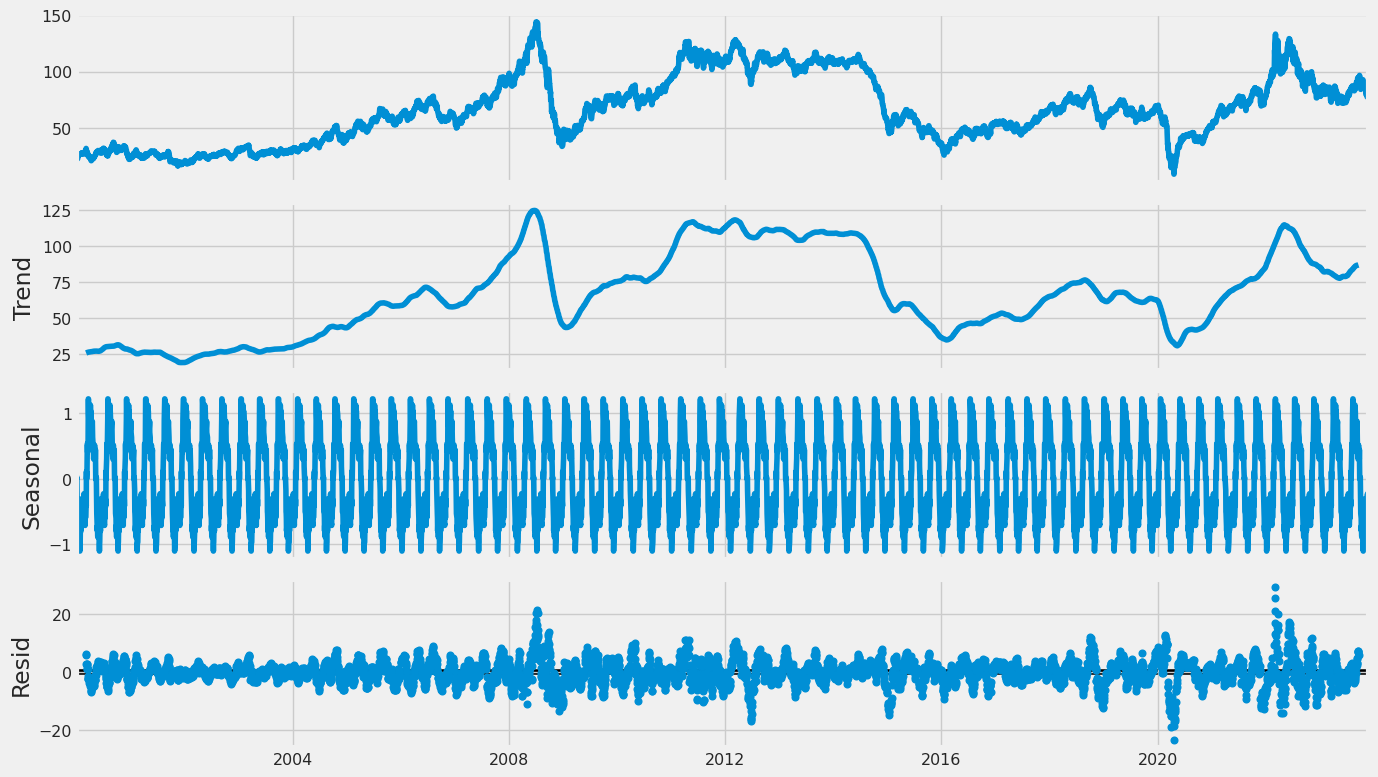

In [20]:
rcParams['figure.figsize'] = 14, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period = 90)
fig = decomposition.plot()
plt.show()

In [21]:
# normalize the data_set
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [22]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [ ]:
len(test)

1756

In [24]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [ ]:
# reshape into X=t and Y=t+1
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
# reshape into X=t and Y=t+1
look_back =10
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [27]:
# create and fit the LSTM network model = Sequential()
model = Sequential()

model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(0.1))

model.add(LSTM(units = 60))
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =model.fit(X_train, Y_train, epochs = 20, batch_size = 32,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
133/133 [==============================] - 12s 31ms/step - loss: 0.0064 - val_loss: 0.0607 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - 3s 25ms/step - loss: 0.0143 - val_loss: 0.0489 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - 6s 43ms/step - loss: 0.0191 - val_loss: 0.0244 - lr: 0.0010
Epoch 4/20
133/133 [==============================] - 3s 23ms/step - loss: 0.0157 - val_loss: 0.0144 - lr: 0.0010
Epoch 5/20
133/133 [==============================] - 4s 27ms/step - loss: 0.0094 - val_loss: 0.0083 - lr: 0.0010
Epoch 6/20
133/133 [==============================] - 3s 22ms/step - loss: 0.0040 - val_loss: 8.3754e-04 - lr: 0.0010
Epoch 7/20
133/133 [==============================] - 4s 32ms/step - loss: 0.0014 - val_loss: 0.0016 - lr: 0.0010
Epoch 8/20
133/133 [==============================] - 3s 25ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/20
133/133 [==============================] - 3s 22ms/step - loss: 0.0015 -

In [28]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

57/57 [==============================] - 0s 6ms/step


In [29]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Root Mean Squared Error: 2.8987308754606835
Test Root Mean Squared Error: 3.471189332948495


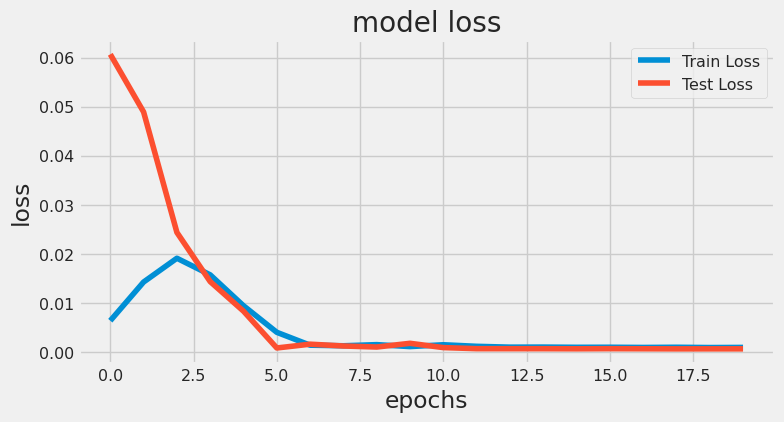

In [30]:
#print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
#print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

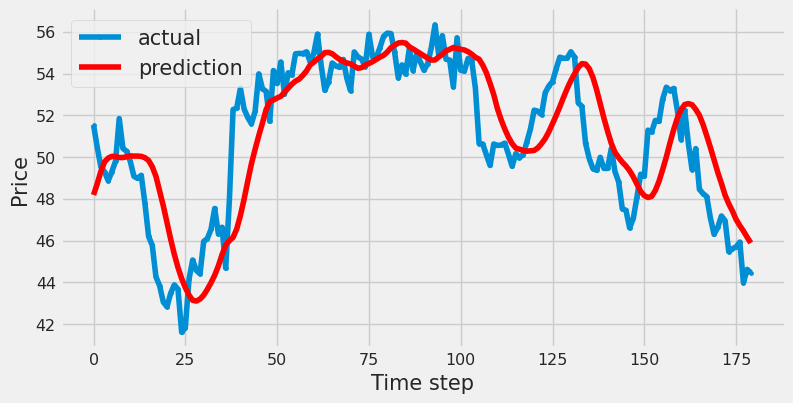

In [31]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

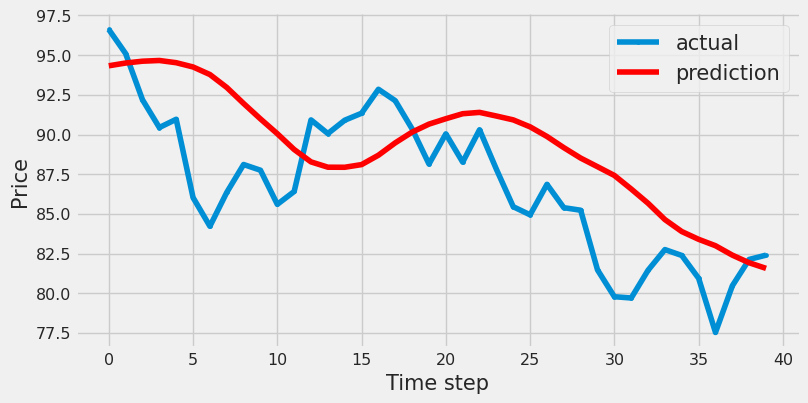

In [32]:
#Compare Actual vs. Prediction
aa=[x for x in range(40)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][-40:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][-40:], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [33]:
Y_test[-10:]

array([[51.54, 50.48, 49.53, ..., 80.47, 82.13, 82.4 ]])

In [35]:
Y_test_r = Y_test.reshape(len(Y_test[0]), 1)
Y_test_r[-10:]

In [56]:
Y_test_inc = np.greater_equal(Y_test_r[1:], Y_test_r[:-1]).astype(int)
test_predict_inc = np.greater_equal(test_predict[1:], test_predict[:-1]).astype(int)


In [61]:
Y_train_r = Y_train.reshape(len(Y_train[0]), 1)
Y_train_inc = np.greater_equal(Y_train_r[1:], Y_train_r[:-1]).astype(int)
train_predict_inc = np.greater_equal(train_predict[1:], train_predict[:-1]).astype(int)

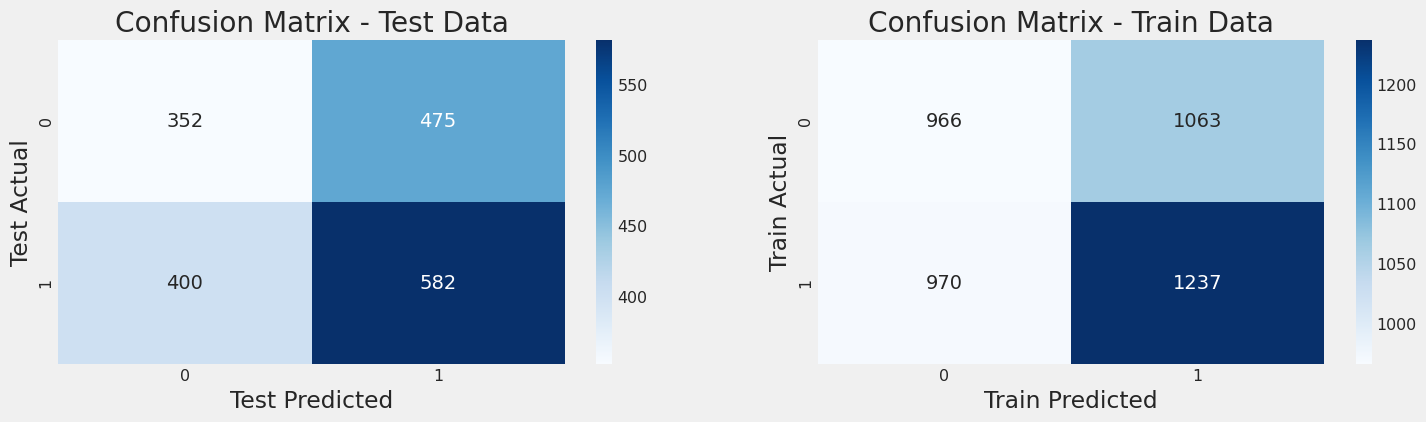

In [68]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix_test = confusion_matrix(Y_test_inc, test_predict_inc)
conf_matrix_train = confusion_matrix(Y_train_inc, train_predict_inc)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Test Predicted')
plt.ylabel('Test Actual')
plt.title('Confusion Matrix - Test Data')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Train Predicted')
plt.ylabel('Train Actual')
plt.title('Confusion Matrix - Train Data')

plt.show()

In [67]:
classificationreport = classification_report(Y_test_inc, test_predict_inc)
print("Classification Report (Test Data):")
print(classificationreport)


# Adding some space between the reports for clarity
print("\n" + "=" * 40 + "\n")

classification_report2 = classification_report(Y_train_inc, train_predict_inc)
print("Classification Report (Train Data):")
print(classification_report2)


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.47      0.43      0.45       827
           1       0.55      0.59      0.57       982

    accuracy                           0.52      1809
   macro avg       0.51      0.51      0.51      1809
weighted avg       0.51      0.52      0.51      1809



Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2029
           1       0.54      0.56      0.55      2207

    accuracy                           0.52      4236
   macro avg       0.52      0.52      0.52      4236
weighted avg       0.52      0.52      0.52      4236

